# Plot all channels for one site

This notebook demonstrates how to retrieve and plot all channels for one
site using the
[jump_portrait](https://github.com/broadinstitute/monorepo/tree/main/libs/jump_portrait)
library.

In [1]:
import matplotlib.colors as mpl  # noqa: CPY001
import numpy as np
import polars as pl
from jump_portrait.fetch import get_item_location_info, get_jump_image
from matplotlib import pyplot as plt

First, we need to get location information telling us where all images
corresponding to a specific perturbation can be found. We will use the
“get_item_location” function from jump_portrait for this. Here we
retrieve image locations for the “RAB30” gene:

In [2]:
gene_info = get_item_location_info("RAB30")
gene_info.shape

(90, 28)

There are 90 images: 9 sites/well X 5 replicate wells X 2 data types
(CRISPR & ORF). We can also retrieve locations for compound data. By
default, the function assumes a query by INCHI key. We can also query by
JCP ID by specifying the query column:

In [3]:
cmpd_info_byinchi = get_item_location_info("CLETVKMYAXARPO-UHFFFAOYSA-N")
cmpd_info_byjcp = get_item_location_info("JCP2022_011844", input_column="JCP2022")

print(cmpd_info_byinchi.shape)
print(cmpd_info_byjcp.shape)

(34, 28)
(34, 28)

There are 34 sites corresponding to this compound. We’ve written a
function to display all channels for a specific image. Note that this is
just one possible way to display images - we’ve included the function
here so that you can modify it to suit your own needs.

In [4]:
def display_site(
    source: str,
    batch: str,
    plate: str,
    well: str,
    site: str,
    label: str,
    int_percentile: float,
) -> None:
    """Plot all channels from one image.

    Parameters
    ----------
    source : String
        Source ID for image of interest.
    batch : String
        Batch ID for image of interest.
    plate : String
        Plate ID for image of interest.
    well : String
        Well ID for image of interest.
    site : String
        Site ID for image of interest.
    label : String
        Label to display in lower left corner.
    int_percentile: float
        Rescale the image from 0 - this percentile of intensity values.

    """
    n_rows = 2
    n_cols = 3

    # Make images
    axes = plt.subplots(n_rows, n_cols, figsize=(2.6 * n_cols, 2.6 * n_rows))[1]
    axes = axes.ravel()
    counter = 0

    channel_rgb = {
        "AGP": "#FF7F00", # Orange
        "DNA": "#0000FF", # Blue
        "ER": "#00FF00", # Green
        "Mito": "#FF0000", # Red
        "RNA": "#FFFF00", # Yellow
    }

    for ax, (channel, rgb) in zip(axes, channel_rgb.items()):
        cmap = mpl.LinearSegmentedColormap.from_list(channel, ("#000", rgb))

        img = get_jump_image(source, batch, plate, well, channel, site, None)

        ax.imshow(img, vmin=0, vmax=np.percentile(img, int_percentile), cmap=cmap)
        ax.axis("off")

        # Add channel name label in the top left corner
        ax.text(
            0.05,
            0.95,
            channel,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=18,
            color="black",
            bbox=dict(
                facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"
            ),
            transform=ax.transAxes,
        )

    # put label in last subplot
    ax = axes[-1]
    ax.text(
        0.5,
        0.5,
        label,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=20,
        color="black",
        transform=ax.transAxes,
    )
    ax.axis("off")

    # show plot
    plt.tight_layout()

We can get the required location parameters from the location info that
we retrieved earlier. Here we get parameters for the first site in the
JCP compound results:

In [5]:
source, batch, plate, well, site, *rest = cmpd_info_byjcp.row(0)

Next, we define the label and make the plot:

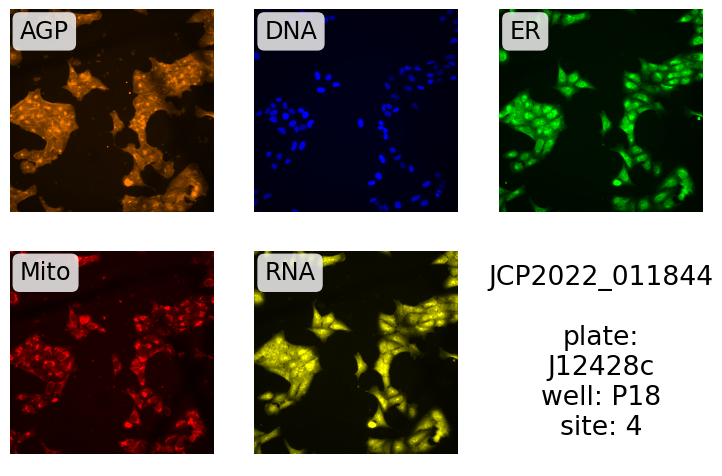

In [6]:
label = "{}\n\nplate:\n{}\nwell: {}\nsite: {}"

display_site(
    source,
    batch,
    plate,
    well,
    site,
    label.format("JCP2022_011844", plate, well, site),
    99.5,
)

Here, we plot one of the RAB30 ORF images:

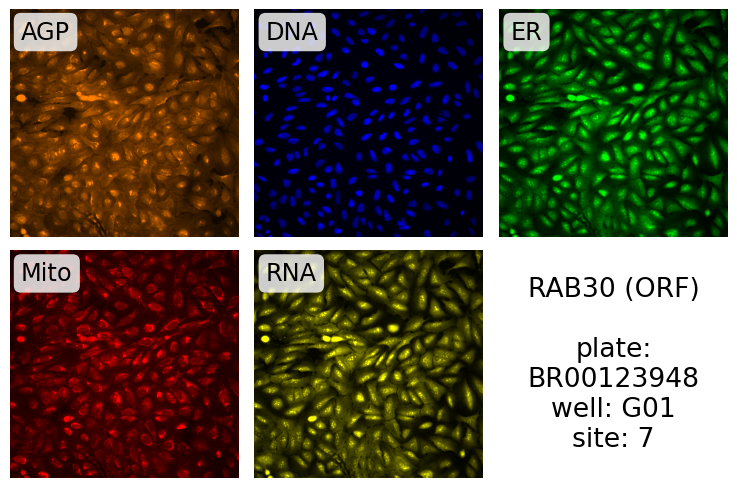

In [7]:
source, batch, plate, well, site, *rest = gene_info.filter(
    pl.col("Metadata_PlateType") == "ORF"
).row(0)
display_site(
    source,
    batch,
    plate,
    well,
    site,
    label.format("RAB30 (ORF)", plate, well, site),
    99.5,
)

And for CRISPR:

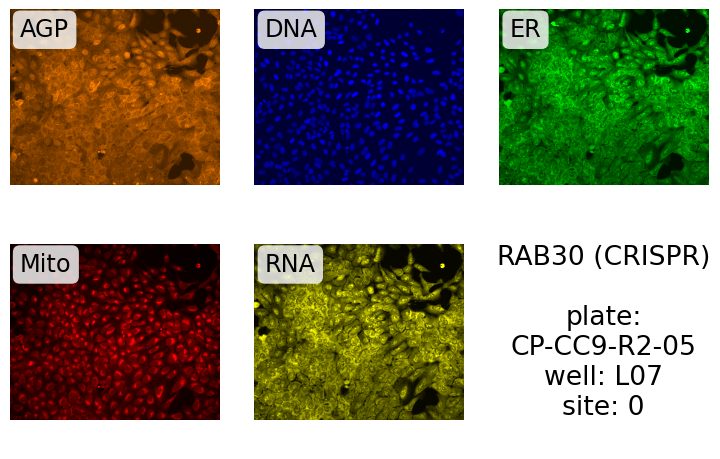

In [8]:
source, batch, plate, well, site, *rest = gene_info.filter(
    pl.col("Metadata_PlateType") == "CRISPR"
).row(0)
display_site(
    source,
    batch,
    plate,
    well,
    site,
    label.format("RAB30 (CRISPR)", plate, well, site),
    99.5,
)